# Stage 1 Training Analysis: Binary DR Classification

This notebook loads the training history from **Stage 1 (Binary DR Classification)** and visualizes all key metrics including:
- Training & Validation Loss curves
- Sensitivity (Recall) & Specificity over epochs
- Accuracy over epochs
- AUC-ROC over epochs
- Confusion Matrix from the best checkpoint
- Classification Report
- Combined metrics dashboard

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path (notebooks/phase 3/ -> project root)
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Paths
STAGE1_DIR = project_root / 'models' / 'stage1_dr_binary'
HISTORY_FILE = STAGE1_DIR / 'training_history.json'
BEST_CHECKPOINT = STAGE1_DIR / 'best.pt'

print(f"Project root: {project_root}")
print(f"Stage 1 model dir: {STAGE1_DIR}")
print(f"History file exists: {HISTORY_FILE.exists()}")
print(f"Best checkpoint exists: {BEST_CHECKPOINT.exists()}")

Project root: d:\TAB\Mine\College\SEM 7\GR\eye-realtime-inference
Stage 1 model dir: d:\TAB\Mine\College\SEM 7\GR\eye-realtime-inference\models\stage1_dr_binary
History file exists: True
Best checkpoint exists: True


## 1. Load Training History

In [2]:
# Load training history
with open(HISTORY_FILE, 'r') as f:
    history = json.load(f)

epochs = list(range(1, len(history['train_loss']) + 1))
num_epochs = len(epochs)

print(f"Total epochs trained: {num_epochs}")
print(f"\nMetrics tracked:")
for key in history:
    print(f"  - {key}: {len(history[key])} values")

# Summary statistics
print(f"\n{'='*50}")
print(f"TRAINING SUMMARY")
print(f"{'='*50}")
print(f"Final Train Loss:     {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss:       {history['val_loss'][-1]:.4f}")
print(f"Best Val Sensitivity: {max(history['val_sensitivity']):.4f} (Epoch {np.argmax(history['val_sensitivity']) + 1})")
print(f"Best Val Specificity: {max(history['val_specificity']):.4f} (Epoch {np.argmax(history['val_specificity']) + 1})")
print(f"Best Val Accuracy:    {max(history['val_accuracy']):.4f} (Epoch {np.argmax(history['val_accuracy']) + 1})")
print(f"Best Val AUC-ROC:     {max(history['val_auc_roc']):.4f} (Epoch {np.argmax(history['val_auc_roc']) + 1})")

Total epochs trained: 13

Metrics tracked:
  - train_loss: 13 values
  - val_loss: 13 values
  - val_sensitivity: 13 values
  - val_specificity: 13 values
  - val_accuracy: 13 values
  - val_auc_roc: 13 values

TRAINING SUMMARY
Final Train Loss:     0.1895
Final Val Loss:       0.2963
Best Val Sensitivity: 0.8342 (Epoch 3)
Best Val Specificity: 0.8249 (Epoch 6)
Best Val Accuracy:    0.7867 (Epoch 13)
Best Val AUC-ROC:     0.8300 (Epoch 12)


## 2. Training & Validation Loss Curves

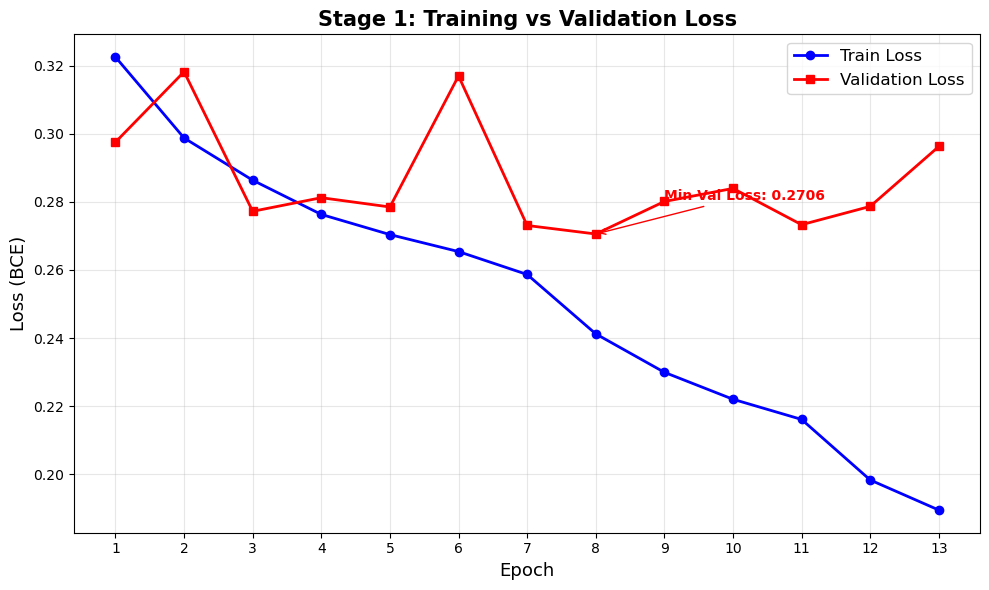

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epochs, history['train_loss'], 'b-o', linewidth=2, markersize=6, label='Train Loss')
ax.plot(epochs, history['val_loss'], 'r-s', linewidth=2, markersize=6, label='Validation Loss')

ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Loss (BCE)', fontsize=13)
ax.set_title('Stage 1: Training vs Validation Loss', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)

# Annotate min val loss
min_val_idx = np.argmin(history['val_loss'])
ax.annotate(f"Min Val Loss: {history['val_loss'][min_val_idx]:.4f}",
            xy=(epochs[min_val_idx], history['val_loss'][min_val_idx]),
            xytext=(epochs[min_val_idx]+1, history['val_loss'][min_val_idx]+0.01),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Sensitivity & Specificity Over Epochs

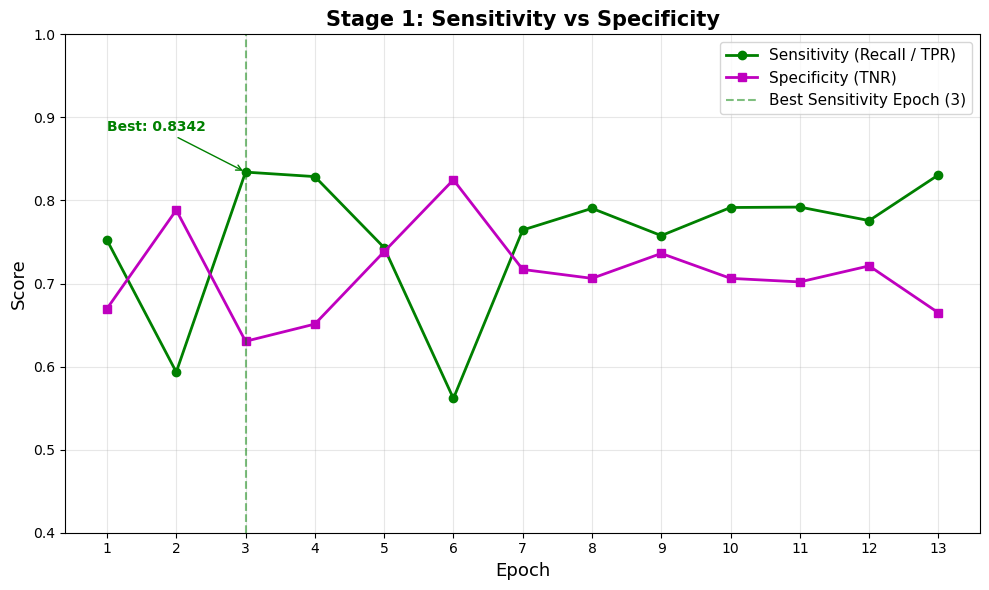

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epochs, history['val_sensitivity'], 'g-o', linewidth=2, markersize=6, label='Sensitivity (Recall / TPR)')
ax.plot(epochs, history['val_specificity'], 'm-s', linewidth=2, markersize=6, label='Specificity (TNR)')

ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Stage 1: Sensitivity vs Specificity', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)
ax.set_ylim(0.4, 1.0)

# Highlight best sensitivity
best_sens_idx = np.argmax(history['val_sensitivity'])
ax.axvline(x=epochs[best_sens_idx], color='green', linestyle='--', alpha=0.5, label=f'Best Sensitivity Epoch ({epochs[best_sens_idx]})')
ax.annotate(f"Best: {history['val_sensitivity'][best_sens_idx]:.4f}",
            xy=(epochs[best_sens_idx], history['val_sensitivity'][best_sens_idx]),
            xytext=(epochs[best_sens_idx]-2, history['val_sensitivity'][best_sens_idx]+0.05),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=10, color='green', fontweight='bold')

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 4. Validation Accuracy Over Epochs

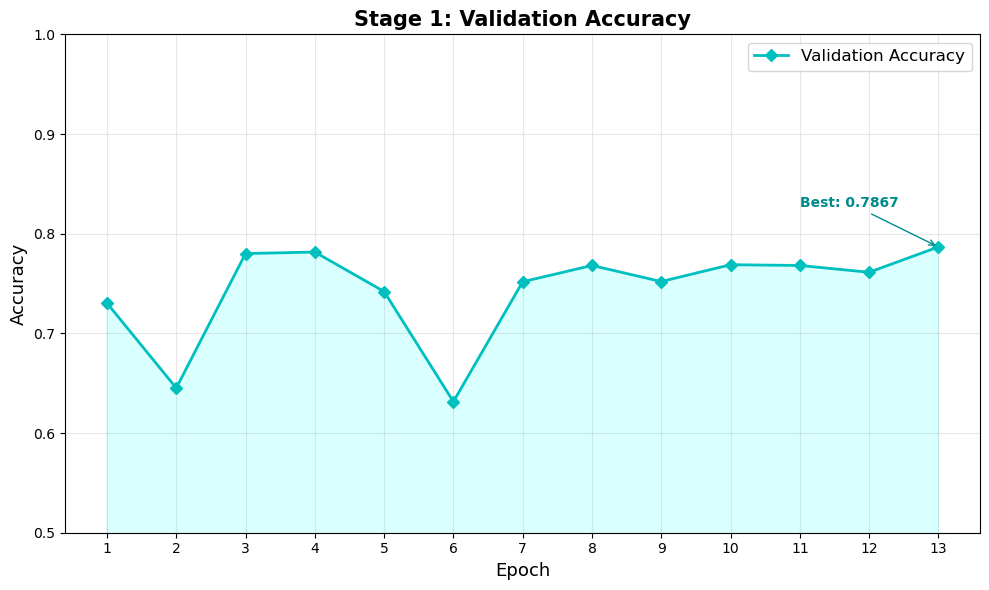

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epochs, history['val_accuracy'], 'c-D', linewidth=2, markersize=6, label='Validation Accuracy')
ax.fill_between(epochs, history['val_accuracy'], alpha=0.15, color='cyan')

ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('Stage 1: Validation Accuracy', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)
ax.set_ylim(0.5, 1.0)

# Annotate best accuracy
best_acc_idx = np.argmax(history['val_accuracy'])
ax.annotate(f"Best: {history['val_accuracy'][best_acc_idx]:.4f}",
            xy=(epochs[best_acc_idx], history['val_accuracy'][best_acc_idx]),
            xytext=(epochs[best_acc_idx]-2, history['val_accuracy'][best_acc_idx]+0.04),
            arrowprops=dict(arrowstyle='->', color='darkcyan'),
            fontsize=10, color='darkcyan', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. AUC-ROC Over Epochs

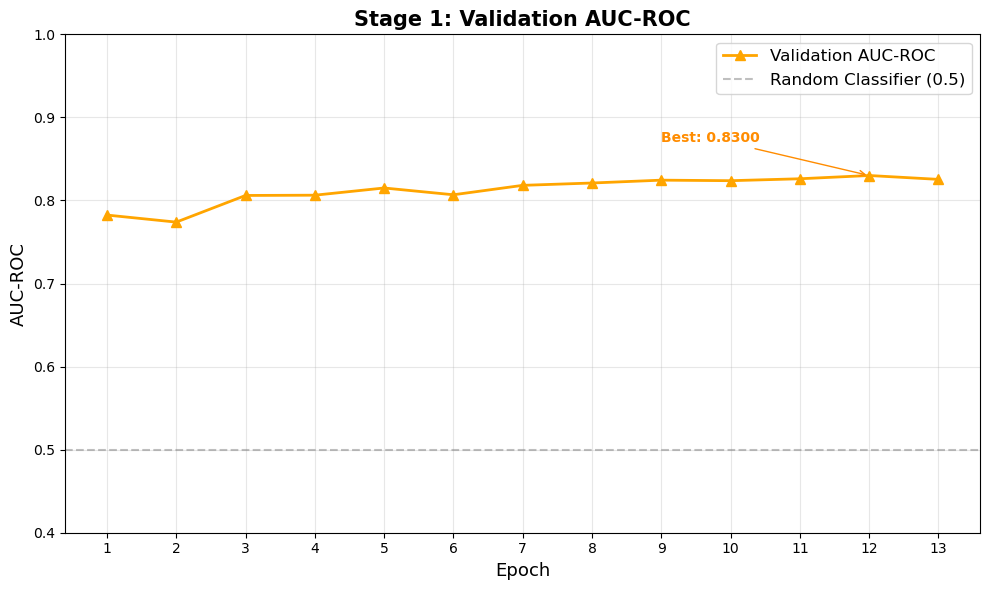

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epochs, history['val_auc_roc'], 'orange', marker='^', linewidth=2, markersize=7, label='Validation AUC-ROC')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Classifier (0.5)')

ax.set_xlabel('Epoch', fontsize=13)
ax.set_ylabel('AUC-ROC', fontsize=13)
ax.set_title('Stage 1: Validation AUC-ROC', fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs)
ax.set_ylim(0.4, 1.0)

# Annotate best AUC
best_auc_idx = np.argmax(history['val_auc_roc'])
ax.annotate(f"Best: {history['val_auc_roc'][best_auc_idx]:.4f}",
            xy=(epochs[best_auc_idx], history['val_auc_roc'][best_auc_idx]),
            xytext=(epochs[best_auc_idx]-3, history['val_auc_roc'][best_auc_idx]+0.04),
            arrowprops=dict(arrowstyle='->', color='darkorange'),
            fontsize=10, color='darkorange', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Combined Metrics Dashboard

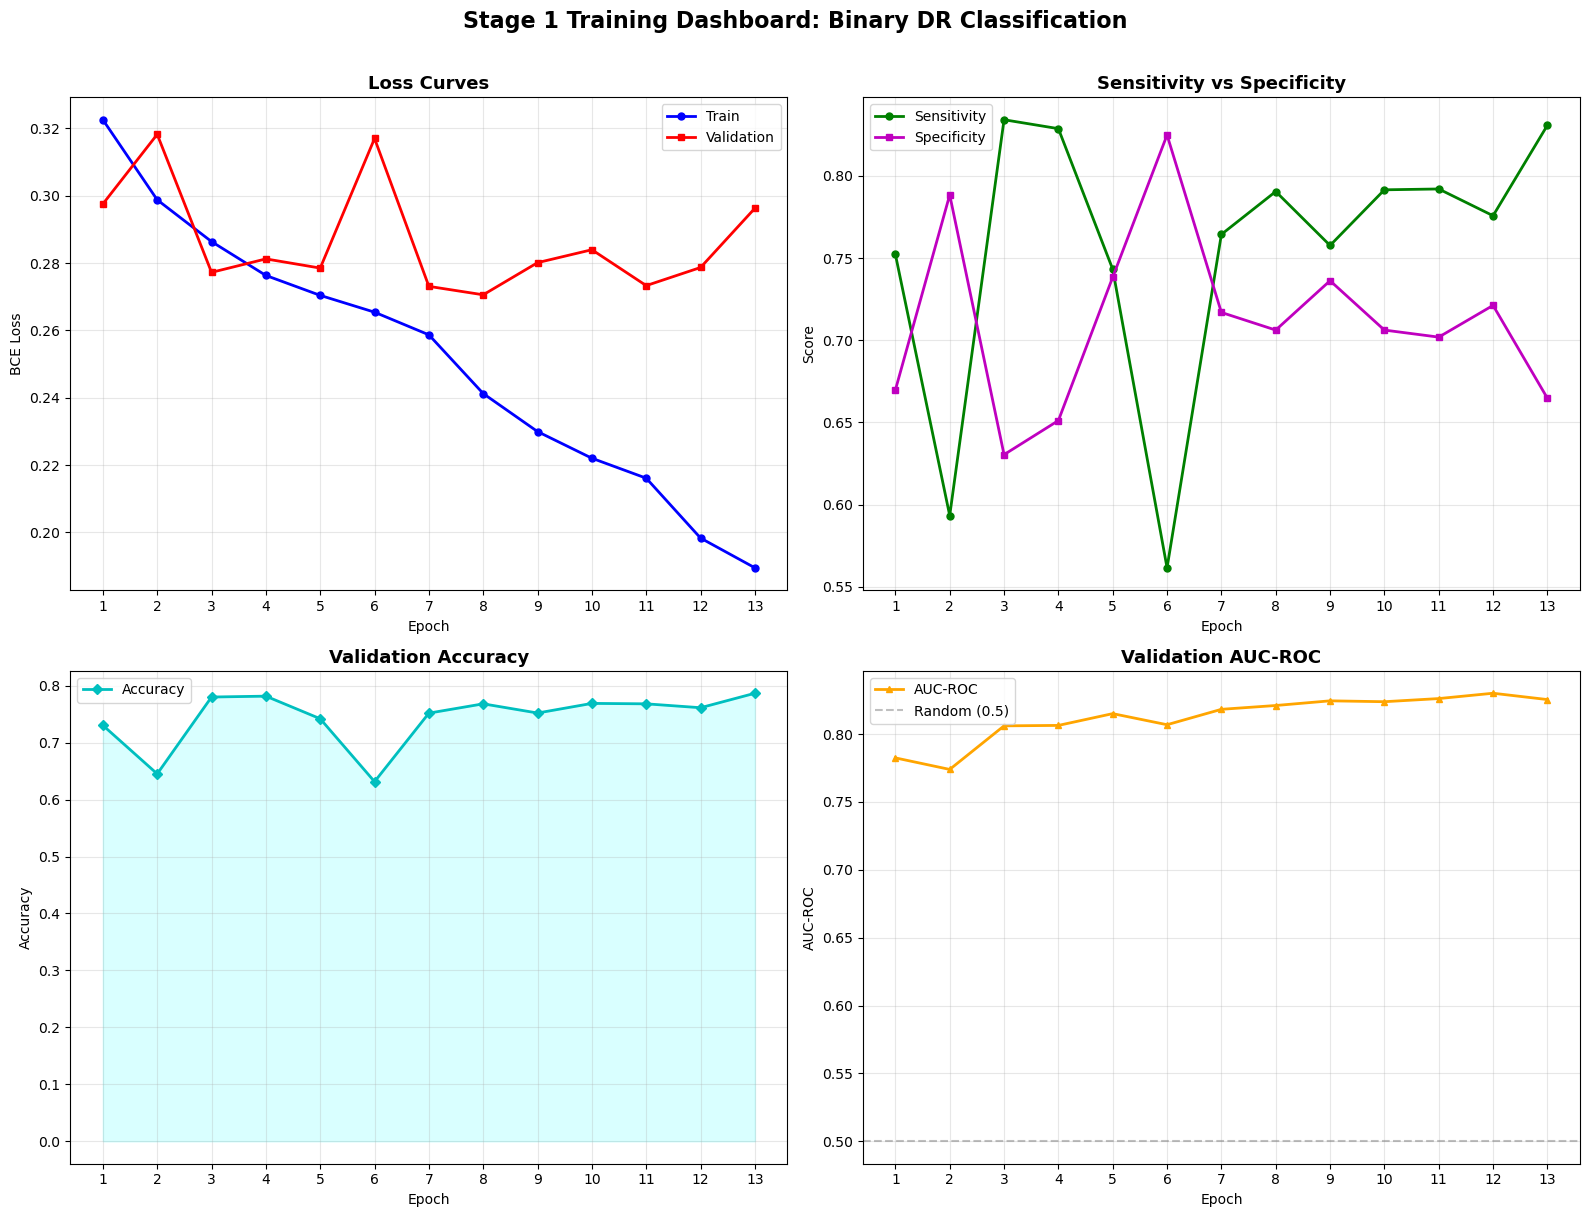

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stage 1 Training Dashboard: Binary DR Classification', fontsize=16, fontweight='bold', y=1.01)

# Plot 1: Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-o', linewidth=2, markersize=5, label='Train')
axes[0, 0].plot(epochs, history['val_loss'], 'r-s', linewidth=2, markersize=5, label='Validation')
axes[0, 0].set_title('Loss Curves', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('BCE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(epochs)

# Plot 2: Sensitivity & Specificity
axes[0, 1].plot(epochs, history['val_sensitivity'], 'g-o', linewidth=2, markersize=5, label='Sensitivity')
axes[0, 1].plot(epochs, history['val_specificity'], 'm-s', linewidth=2, markersize=5, label='Specificity')
axes[0, 1].set_title('Sensitivity vs Specificity', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(epochs)

# Plot 3: Accuracy
axes[1, 0].plot(epochs, history['val_accuracy'], 'c-D', linewidth=2, markersize=5, label='Accuracy')
axes[1, 0].fill_between(epochs, history['val_accuracy'], alpha=0.15, color='cyan')
axes[1, 0].set_title('Validation Accuracy', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(epochs)

# Plot 4: AUC-ROC
axes[1, 1].plot(epochs, history['val_auc_roc'], 'orange', marker='^', linewidth=2, markersize=5, label='AUC-ROC')
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (0.5)')
axes[1, 1].set_title('Validation AUC-ROC', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC-ROC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(epochs)

plt.tight_layout()
plt.show()

## 7. Per-Epoch Metrics Table

In [8]:
import pandas as pd

# Build a DataFrame from history
df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': [f"{v:.4f}" for v in history['train_loss']],
    'Val Loss': [f"{v:.4f}" for v in history['val_loss']],
    'Sensitivity': [f"{v:.4f}" for v in history['val_sensitivity']],
    'Specificity': [f"{v:.4f}" for v in history['val_specificity']],
    'Accuracy': [f"{v:.4f}" for v in history['val_accuracy']],
    'AUC-ROC': [f"{v:.4f}" for v in history['val_auc_roc']],
})
df = df.set_index('Epoch')

# Highlight the best epoch (by sensitivity)
best_epoch = np.argmax(history['val_sensitivity']) + 1
print(f"Best epoch (by sensitivity): Epoch {best_epoch}")
print()
df

Best epoch (by sensitivity): Epoch 3



,Train Loss,Val Loss,Sensitivity,Specificity,Accuracy,AUC-ROC
Epoch,,,,,,
1,0.3225,0.2975,0.7523,0.6698,0.7304,0.7824
2,0.2988,0.3182,0.5934,0.7884,0.6452,0.7739
3,0.2864,0.2772,0.8342,0.6305,0.7801,0.8060
4,0.2763,0.2812,0.8287,0.6512,0.7816,0.8063
5,0.2704,0.2785,0.7432,0.7384,0.7419,0.8150
6,0.2654,0.3170,0.5616,0.8249,0.6315,0.8069
7,0.2587,0.2731,0.7644,0.7169,0.7518,0.8182
8,0.2412,0.2706,0.7905,0.7062,0.7681,0.8210
9,0.2299,0.2801,0.7577,0.7362,0.7520,0.8245


## 8. Confusion Matrix from Best Checkpoint

Load the best checkpoint and extract the confusion matrix metrics (TP, TN, FP, FN) stored in the checkpoint.

In [9]:
# Load best checkpoint
checkpoint = torch.load(BEST_CHECKPOINT, map_location='cpu', weights_only=False)

print("Checkpoint keys:", list(checkpoint.keys()))
print(f"\nBest checkpoint epoch: {checkpoint['epoch']}")
print(f"Best val sensitivity:  {checkpoint['best_val_sensitivity']:.4f}")
print(f"\nMetrics from best checkpoint:")
for k, v in checkpoint['metrics'].items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Checkpoint keys: ['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'metrics', 'best_val_sensitivity', 'train_history']

Best checkpoint epoch: 3
Best val sensitivity:  0.8342

Metrics from best checkpoint:
  accuracy: 0.7801
  precision: 0.8620
  recall: 0.8342
  sensitivity: 0.8342
  specificity: 0.6305
  f1_score: 0.8478
  true_positives: 3229
  true_negatives: 882
  false_positives: 517
  false_negatives: 642
  auc_roc: 0.8060


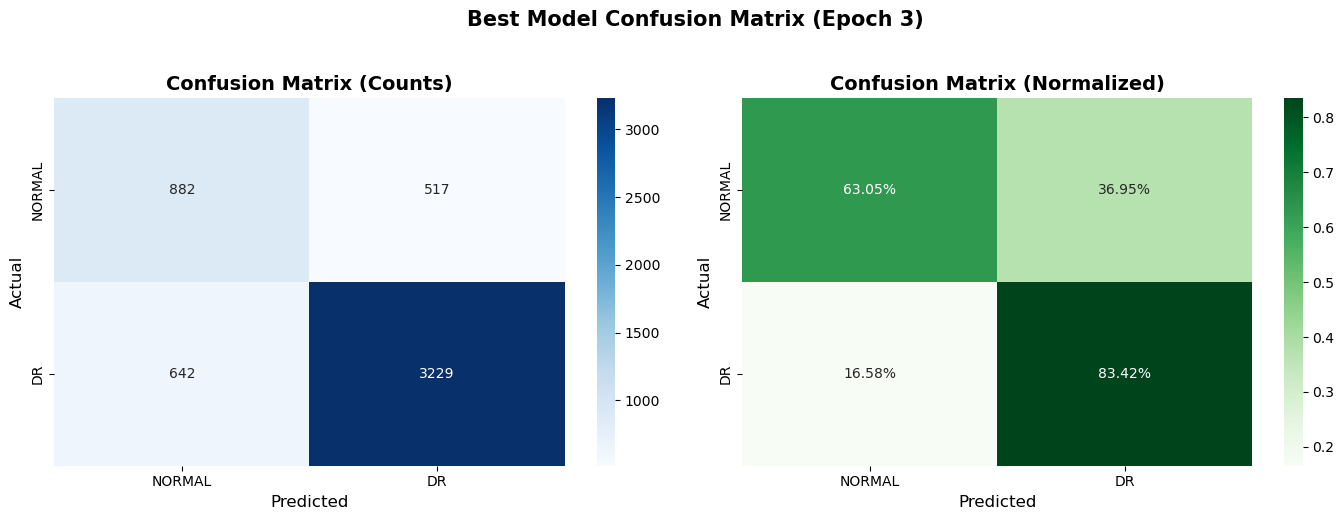


True Positives  (DR correctly detected):    3229
True Negatives  (NORMAL correctly detected):  882
False Positives (NORMAL misclassified as DR): 517
False Negatives (DR missed):                  642


In [11]:
# Build confusion matrix from checkpoint metrics
metrics = checkpoint['metrics']
tp = metrics.get('true_positives', 0)
tn = metrics.get('true_negatives', 0)
fp = metrics.get('false_positives', 0)
fn = metrics.get('false_negatives', 0)

cm = np.array([[tn, fp],
               [fn, tp]])

class_names = ['NORMAL', 'DR']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Normalized (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.suptitle(f'Best Model Confusion Matrix (Epoch {checkpoint["epoch"]})', fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print(f"\nTrue Positives  (DR correctly detected):    {tp}")
print(f"True Negatives  (NORMAL correctly detected):  {tn}")
print(f"False Positives (NORMAL misclassified as DR): {fp}")
print(f"False Negatives (DR missed):                  {fn}")

## 9. Final Metrics Bar Chart

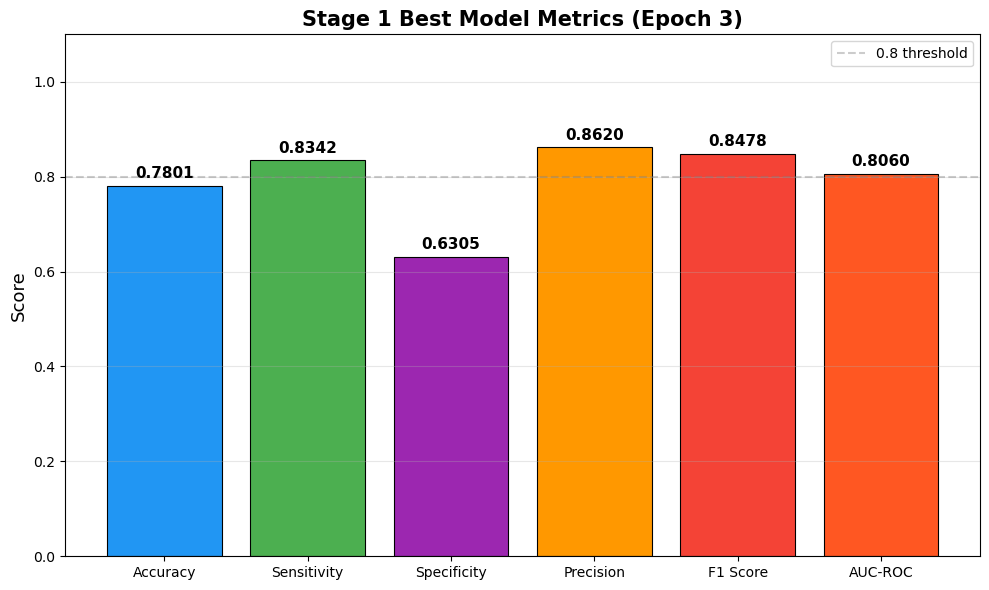

In [12]:
# Bar chart of best-epoch metrics
metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUC-ROC']
metric_values = [
    metrics.get('accuracy', 0),
    metrics.get('sensitivity', 0),
    metrics.get('specificity', 0),
    metrics.get('precision', 0),
    metrics.get('f1_score', 0),
    metrics.get('auc_roc', 0),
]

colors = ['#2196F3', '#4CAF50', '#9C27B0', '#FF9800', '#F44336', '#FF5722']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metric_names, metric_values, color=colors, edgecolor='black', linewidth=0.8)

# Add value labels on bars
for bar, val in zip(bars, metric_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=13)
ax.set_title(f'Stage 1 Best Model Metrics (Epoch {checkpoint["epoch"]})', fontsize=15, fontweight='bold')
ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.4, label='0.8 threshold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Training Convergence Analysis

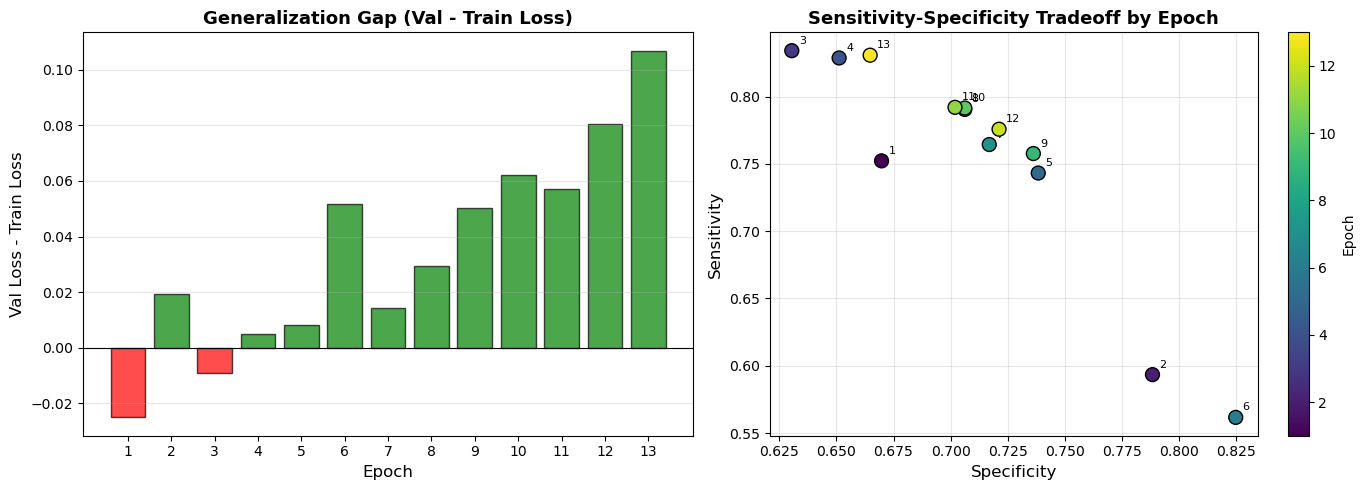

Average generalization gap: 0.0346
Final generalization gap:   0.1068
Model generalization looks healthy.


In [13]:
# Overfitting gap analysis
loss_gap = [v - t for t, v in zip(history['train_loss'], history['val_loss'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss gap
axes[0].bar(epochs, loss_gap, color=['green' if g > 0 else 'red' for g in loss_gap], alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='black', linewidth=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Val Loss - Train Loss', fontsize=12)
axes[0].set_title('Generalization Gap (Val - Train Loss)', fontsize=13, fontweight='bold')
axes[0].set_xticks(epochs)
axes[0].grid(axis='y', alpha=0.3)

# Sensitivity-Specificity tradeoff
axes[1].scatter(history['val_specificity'], history['val_sensitivity'], 
                c=epochs, cmap='viridis', s=100, edgecolors='black', zorder=5)
for i, ep in enumerate(epochs):
    axes[1].annotate(str(ep), (history['val_specificity'][i], history['val_sensitivity'][i]),
                     textcoords='offset points', xytext=(5, 5), fontsize=8)
axes[1].set_xlabel('Specificity', fontsize=12)
axes[1].set_ylabel('Sensitivity', fontsize=12)
axes[1].set_title('Sensitivity-Specificity Tradeoff by Epoch', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

# Summary
print(f"Average generalization gap: {np.mean(loss_gap):.4f}")
print(f"Final generalization gap:   {loss_gap[-1]:.4f}")
if np.mean(loss_gap) > 0.05:
    print("Warning: Model may be slightly overfitting (gap > 0.05)")
else:
    print("Model generalization looks healthy.")